# GA Project 4: West Nile Virus
by: Nicholas Lim, Kwek Jun Hong, Malcolm Lau
***

## Notebook organisation
- **Notebook 1: Data Cleaning, EDA and Feature Engineering (current notebook)**
- Notebook 2: Model Tuning, Evaluation and Cost Benefit Analysis


# Background
***
The city of Chicago has been having to deal with seasonal upticks of incidences of the West Nile virus, and it is becoming a health hazard. We have been tasked by the Chicago Department of Public Health to come up with a predictive model to identify locations where mosquitoes would have a higher chance of carrying the disease, so that resources can be effectively allocated to stop its spread.

One of the more efficient ways to prevent the disease would be to spray Zenivex, a pesticide, and by identifying the potential hotspots we can find an effective balance between preventability and cost. To this end, we will be examining the [West Nile Virus dataset](www.kaggle.com/c/predict-west-nile-virus/data) to train a model which can effectively predict the prevalence of the virus in certain areas.



# Problem Statement
***
To train a model which can predict the prevalence of the West Nile virus amongst mosquitoes within the Chicago city area, and to run a cost-benefit analysis to determine the most effective way to apply pesticides.

# Approach
---

We will be looking at the seasonal trends of the incidences of the West Nile virus amongst mosquitoes in the Chicago city center area, and to understand the effects of weather on the prevalence of the virus. We will then examine four models (logistic regression, random forest, gradient boost classifier, and XGBoost classifier) to predict the probability of the virus being present in the even-valued years missing in our dataset. Finally, the models will be scored based on their ROC-AUC and F1 scores, and we will submit our model predictions to the [kaggle competition](https://www.kaggle.com/c/predict-west-nile-virus/overview) to be graded.

# Imports

In [1]:
# fabulous four
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# etc
import re
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Load Data

We can start by cleaning up the column names. We can create a function to clean them at one go that will
1. remove whitespaces at the front and end
2. change whitespaces in the middle to `_`
3. change capitals to lowercase

In [2]:
def pythonic_cols(df):
    new_cols = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).strip().lower() for name in df.columns]
    df.columns = new_cols

In [3]:
train = pd.read_csv('data/train.csv')
pythonic_cols(train)
display(train.head())
train.shape

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


(10506, 12)

In [4]:
weather = pd.read_csv('data/weather.csv')
pythonic_cols(weather)
display(weather.head())
weather.shape

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


(2944, 22)

In [5]:
spray = pd.read_csv('data/spray.csv')
pythonic_cols(spray)
display(spray.head())
spray.shape

,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


(14835, 4)

In [6]:
test = pd.read_csv('data/test.csv')
pythonic_cols(test)
display(test.head())
test.shape

,id,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


(116293, 11)

# Dependent Variable

Let's first take a look at the dependent variable. We can see that it is severely imbalanced, which will have to be addressed later.

In [7]:
train.wnv_present.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnv_present, dtype: float64

# Feature Selection

We can choose the features that are relevant to our analysis from each dataset and combine them for easier data cleaning and analysis.

## `train`/`test` datasets

The `train` and `test` datasets can be examined and cleaned at the same time as both datasets contain similar columns (except for the dependent variable). 

In [8]:
train.head()

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       10506 non-null  object 
 1   address                    10506 non-null  object 
 2   species                    10506 non-null  object 
 3   block                      10506 non-null  int64  
 4   street                     10506 non-null  object 
 5   trap                       10506 non-null  object 
 6   address_number_and_street  10506 non-null  object 
 7   latitude                   10506 non-null  float64
 8   longitude                  10506 non-null  float64
 9   address_accuracy           10506 non-null  int64  
 10  num_mosquitos              10506 non-null  int64  
 11  wnv_present                10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         116293 non-null  int64  
 1   date                       116293 non-null  object 
 2   address                    116293 non-null  object 
 3   species                    116293 non-null  object 
 4   block                      116293 non-null  int64  
 5   street                     116293 non-null  object 
 6   trap                       116293 non-null  object 
 7   address_number_and_street  116293 non-null  object 
 8   latitude                   116293 non-null  float64
 9   longitude                  116293 non-null  float64
 10  address_accuracy           116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


### Address Columns

The address details are not as important to us because location information is sufficiently captured in the Lat/Long provided in the dataset. 

### Trap Column

From the `train` dataset, we can see that the most tested traps were T900 & T115. The top ten tested traps are shown below.

We also observe that there are some traps which exist only in the `test` dataset but not in the `train` dataset. As we will be one-hot encoding nominal variables such as traps, having features that do not exist in the `train` dataset will not be useful. Therefore, we can drop the `trap` column.

In [11]:
plt.figure(figsize=(22,8))
print(train['trap'].value_counts().head(10))

T900    750
T115    542
T138    314
T002    185
T135    183
T054    163
T128    160
T151    156
T212    152
T090    151
Name: trap, dtype: int64


<Figure size 1584x576 with 0 Axes>

In [12]:
for trap in test['trap'].unique():
    if trap not in train['trap'].unique():
        print(trap)

T090A
T090B
T090C
T200A
T128A
T200B
T218A
T218C
T218B
T002A
T002B
T234
T065A


### Features selected for `train`/`test`

Based on the above analysis and our domain knowledge, we will keep the features that are most relevant to us:
1. date
2. species
3. latitude
4. longitude
5. wnv_present (dependent variable)

In [13]:
train = train[['date', 'species', 'latitude', 'longitude','num_mosquitos', 'wnv_present']]
train.head()

,date,species,latitude,longitude,num_mosquitos,wnv_present
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           10506 non-null  object 
 1   species        10506 non-null  object 
 2   latitude       10506 non-null  float64
 3   longitude      10506 non-null  float64
 4   num_mosquitos  10506 non-null  int64  
 5   wnv_present    10506 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 492.6+ KB


Whatever we do for `train`, we have to do unto `test` too, except without the dependent variable.

In [15]:
test = test[['date', 'species', 'latitude', 'longitude']]
test.head()

,date,species,latitude,longitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991
1,2008-06-11,CULEX RESTUANS,41.95469,-87.800991
2,2008-06-11,CULEX PIPIENS,41.95469,-87.800991
3,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991
4,2008-06-11,CULEX TERRITANS,41.95469,-87.800991


## `weather` dataset

In [16]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [17]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station       2944 non-null   int64  
 1   date          2944 non-null   object 
 2   tmax          2944 non-null   int64  
 3   tmin          2944 non-null   int64  
 4   tavg          2944 non-null   object 
 5   depart        2944 non-null   object 
 6   dew_point     2944 non-null   int64  
 7   wet_bulb      2944 non-null   object 
 8   heat          2944 non-null   object 
 9   cool          2944 non-null   object 
 10  sunrise       2944 non-null   object 
 11  sunset        2944 non-null   object 
 12  code_sum      2944 non-null   object 
 13  depth         2944 non-null   object 
 14  water1        2944 non-null   object 
 15  snow_fall     2944 non-null   object 
 16  precip_total  2944 non-null   object 
 17  stn_pressure  2944 non-null   object 
 18  sea_level     2944 non-null 

Taking a look at the nominal variable `code_sum`, we notice that it is a description of weather patterns captured by the weather station on a certain day. However for our case, the rest of the information suffices in giving us an overview of the weather conditions on a particular day, and thus we do not need it.

In [18]:
weather.code_sum.value_counts()

                    1609
RA                   296
RA BR                238
BR                   110
TSRA RA BR            92
                    ... 
RA DZ SN               1
TS TSRA RA FG BR       1
BR HZ VCFG             1
TS RA FG+ FG BR        1
RA SN BR               1
Name: code_sum, Length: 98, dtype: int64

We can also do a check on the precipitation columns. It seems like out of all of them, only the total precipitation column gives the most useful information - the rest are null values.

In [19]:
for col in ['depth', 'water1', 'snow_fall', 'precip_total']:
  print(col)
  print(weather[col].value_counts())
  print('===============')

depth
0    1472
M    1472
Name: depth, dtype: int64
water1
M    2944
Name: water1, dtype: int64
snow_fall
M      1472
0.0    1459
  T      12
0.1       1
Name: snow_fall, dtype: int64
precip_total
0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
3.64       1
4.73       1
1.60       1
2.24       1
1.18       1
Name: precip_total, Length: 168, dtype: int64


According to this [website](https://www.differencebetween.com/difference-between-dewpoint-and-wet-bulb-temperature/), there is a direct correlation between temperature and dewpoint which indicates the humidity. We can then remove the wet bulb temperature. Furthermore, air pressure has a significant impact on the weather patterns in the area.

Based on the above analysis, we will be choosing a few relevant columns for our analysis. The pertinent ones are:
1. station
2. date
3. tavg
4. dew_point
5. sunrise
6. sunset
7. precip_total
8. stn_pressure
9. avg_speed

In [20]:
weather = weather[['station', 'date', 'tavg', 'dew_point', 'precip_total', 'sunrise','sunset', 'stn_pressure', 'avg_speed']]
weather.head()

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,avg_speed
0,1,2007-05-01,67,51,0.00,0448,1849,29.10,9.2
1,2,2007-05-01,68,51,0.00,-,-,29.18,9.6
2,1,2007-05-02,51,42,0.00,0447,1850,29.38,13.4
3,2,2007-05-02,52,42,0.00,-,-,29.44,13.4
4,1,2007-05-03,56,40,0.00,0446,1851,29.39,11.9


# Data Cleaning for `train`, `test` ,`weather` & `spray` datasets

Our data cleaning will involve two steps:
1. imputing missing values
2. changing datatypes

### Missing values

#### `Weather` dataset
It seems like everything is in order and there are no null values, but that is a cruel trick. According to the [data dictionary](https://www.kaggle.com/c/predict-west-nile-virus/data?select=noaa_weather_qclcd_documentation.pdf), there are three types of missing values:
1. `*`: Not all stations report snow totals
2. `M`: Missing Data, or data that are not normally reported for the station
3. `-`: values not available for sunrise/sunset

And additional `T` values for trace amounts. We can write a function to replace them with suitable values.

In [21]:
 def missing_no(df):
    df.replace(r'\s*M+\s*', 0, regex=True, inplace=True)
    df.replace('-', 0, inplace=True)
    df.replace('*', 0, inplace=True)
    df.replace(r'^\s*T+(?!\d)+', 1e-5, regex=True, inplace=True)

In [22]:
missing_no(weather)
weather.head()

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,avg_speed
0,1,2007-05-01,67,51,0.00,0448,1849,29.10,9.2
1,2,2007-05-01,68,51,0.00,0,0,29.18,9.6
2,1,2007-05-02,51,42,0.00,0447,1850,29.38,13.4
3,2,2007-05-02,52,42,0.00,0,0,29.44,13.4
4,1,2007-05-03,56,40,0.00,0446,1851,29.39,11.9


#### `train` dataset

There are no missing values in the train dataset. No missing value imputation is required.

In [23]:
train.isnull().sum()

date             0
species          0
latitude         0
longitude        0
num_mosquitos    0
wnv_present      0
dtype: int64

#### `spray` dataset

There are missing values in the spray dataset - the time information of certain rows are null. It is observed that the rows all come from the same day that spraying was conducted and for some reason, the time information was not specified. As the main temporal feature of the other datasets are in terms of days, time information is not useful and we will drop the time column.

In [24]:
print(spray.isnull().sum())
display(spray[spray['time'].isnull()])

spray.drop('time', axis=1, inplace=True)

date           0
time         584
latitude       0
longitude      0
dtype: int64


,date,time,latitude,longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014
...,...,...,...,...
1609,2011-09-07,NaN,41.995876,-87.811615
1610,2011-09-07,NaN,41.995972,-87.810271
1611,2011-09-07,NaN,41.995684,-87.810319
1612,2011-09-07,NaN,41.994724,-87.810415


There are also duplicate records from 2011-09-07 from 2 different locations at 2 different times. The records at each location at each time are identical, it is highly likely that this may be a recording error. As such, we will remove these duplicate records.

In [25]:
display(spray[spray.duplicated(keep=False)])

spray.drop_duplicates(inplace=True)

,date,latitude,longitude
484,2011-09-07,41.983917,-87.793088
485,2011-09-07,41.983917,-87.793088
489,2011-09-07,41.986460,-87.794225
490,2011-09-07,41.986460,-87.794225
491,2011-09-07,41.986460,-87.794225
...,...,...,...
1025,2011-09-07,41.986460,-87.794225
1026,2011-09-07,41.986460,-87.794225
1027,2011-09-07,41.986460,-87.794225
1028,2011-09-07,41.986460,-87.794225


### Changing dtypes

From the information table, some of the columns aren't in the right dtype. We can create a function to correct all the wrong datatypes.

In [26]:
def changing_types(df):
    df['date'] = pd.to_datetime(df['date'])
    try:
        df['tavg'] = df['tavg'].astype(int)
        df['avg_speed'] = df['avg_speed'].astype(float)
        df['stn_pressure'] = df['stn_pressure'].astype(float)
        df['precip_total'] = df['precip_total'].astype(float)
        df.info()
    except:
        pass

In [27]:
changing_types(weather)
changing_types(train)
changing_types(test)
changing_types(spray)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station       2944 non-null   int64         
 1   date          2944 non-null   datetime64[ns]
 2   tavg          2944 non-null   int64         
 3   dew_point     2944 non-null   int64         
 4   precip_total  2944 non-null   float64       
 5   sunrise       2944 non-null   object        
 6   sunset        2944 non-null   object        
 7   stn_pressure  2944 non-null   float64       
 8   avg_speed     2944 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 207.1+ KB


### Creating `year`, `month` and `week` columns

Additional time related columns will be created from the `date` columns for a more fine-grained analysis of the time periods. Furthermore, since the lifespan of the mosquitoes are about a few weeks, observing a week-by-week change would suffice.

In [28]:
def preprocess_date(df):
    """Function to create additional time related columns"""
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['week_of_year'] = pd.to_datetime(df['date']).dt.isocalendar().week
    return df

In [29]:
# create the columns for both train and test datasets
preprocess_date(train)
preprocess_date(test)
preprocess_date(weather)
preprocess_date(spray);

## Feature Engineering

* Relative Humidity (RH) - High RH leads to [reduced water evaporation rates](https://parasitesandvectors.biomedcentral.com/articles/10.1186/s13071-018-2808-6), which increases the longevity of stagnant water, resulting in more areas for mosquitos to breed and grow. It can be derived from the average temperature and dew point features.


* Daylight Hours - Mosquito activity is shown to be [higher at night](https://pubmed.ncbi.nlm.nih.gov/18047212/). Using the sunrise and sunset timings, the hours of daylight can be derived (i.e. the lower the value, the longer the night-time hours)


There were incorrect records where '60' minutes were recorded for Sunset. We will correct these mistakes, create a new column called `daylight_hours`, and append it to weather. We will also create an `RH` column below using the formula for [RH](https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html).

In [30]:
# Only station 1 records sunrise and sunset hours
weather_1 = weather.loc[weather['station'] == 1]
print('The unique values of sunrise and sunset for station 1:')
print(weather_1['sunset'].unique())

# creating the daylight_hours column
weather_1['sunset'] = weather_1['sunset'].map(lambda x : (str(int(x[0:2]) + 1) + '00') if x[2:4] == '60' else x)

weather_1['sunrise_time'] = weather_1['sunrise'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_1['sunset_time'] = weather_1['sunset'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_1['daylight_hours'] = (weather_1['sunset_time'] - weather_1['sunrise_time']).map(lambda x : round((x.seconds/3600),2))

weather = weather.merge(weather_1[['date','daylight_hours']], on='date')

The unique values of sunrise and sunset for station 1:
['1849' '1850' '1851' '1852' '1853' '1855' '1856' '1857' '1858' '1859'
 '1860' '1901' '1902' '1903' '1904' '1905' '1906' '1907' '1908' '1909'
 '1910' '1911' '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919'
 '1920' '1921' '1922' '1923' '1924' '1925' '1926' '1927' '1928' '1929'
 '1930' '1931' '1900' '1854' '1848' '1846' '1845' '1843' '1842' '1840'
 '1839' '1837' '1835' '1834' '1832' '1831' '1829' '1827' '1826' '1824'
 '1822' '1821' '1819' '1817' '1815' '1814' '1812' '1810' '1809' '1807'
 '1805' '1803' '1760' '1758' '1756' '1755' '1753' '1751' '1749' '1748'
 '1746' '1744' '1742' '1741' '1739' '1737' '1735' '1734' '1732' '1730'
 '1729' '1727' '1725' '1724' '1722' '1720' '1719' '1717' '1715' '1714'
 '1712' '1711' '1709' '1707' '1706' '1704' '1703' '1701' '1660' '1658'
 '1657' '1656' '1654' '1653' '1651' '1650' '1649' '1647']


In [31]:
# creating the humidity column
tavg_celsius = ((weather['tavg'] - 32) * 5 / 9)
dew_point_celsius = ((weather['dew_point'] - 32) * 5 / 9)
vap_press_sat = np.exp((17.625 * tavg_celsius) / (tavg_celsius + 243.04))
vap_press_act = np.exp((17.625 * dew_point_celsius) / (dew_point_celsius + 243.04))
r_humidity = round(((vap_press_act / vap_press_sat) * 100),2)

weather['r_humidity'] = r_humidity
weather.head()

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,1,2007-05-01,67,51,0.0,0448,1849,29.10,9.2,2007,5,18,14.02,56.44
1,2,2007-05-01,68,51,0.0,0,0,29.18,9.6,2007,5,18,14.02,54.53
2,1,2007-05-02,51,42,0.0,0447,1850,29.38,13.4,2007,5,18,14.05,71.20
3,2,2007-05-02,52,42,0.0,0,0,29.44,13.4,2007,5,18,14.05,68.61
4,1,2007-05-03,56,40,0.0,0446,1851,29.39,11.9,2007,5,18,14.08,54.87


# Exploratory Data Analysis

## Distribution of Weather Information for Stations 1 & 2

From the summary statistics below, the distributions of weather information from Stations 1 & 2 are very similar. The measurements will be consolidated into a single measure using the means of the measures of both stations for each day.

In [32]:
print("High-level statistics for weather at Station 1: O'Hare Airport")
display(weather[weather['station']==1].describe())
print("High-level statistics for weather at Station 2: Midway International Airport")
display(weather[weather['station']==2].describe())

High-level statistics for weather at Station 1: O'Hare Airport


,station,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
count,1472.0,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,1.0,66.606658,53.377717,0.134539,29.214457,8.570788,2010.500000,7.500000,30.838995,13.669728,63.403736
std,0.0,10.511437,10.670263,0.421066,1.089193,3.187250,2.292067,1.710526,7.602052,1.489801,11.318025
min,1.0,36.000000,22.000000,0.000000,0.000000,1.900000,2007.000000,5.000000,17.000000,10.400000,32.110000
25%,1.0,60.000000,46.000000,0.000000,29.160000,6.200000,2008.750000,6.000000,24.000000,12.515000,55.355000
50%,1.0,68.000000,54.000000,0.000000,29.260000,8.100000,2010.500000,7.500000,31.000000,14.235000,63.130000
75%,1.0,75.000000,61.250000,0.060000,29.350000,10.400000,2012.250000,9.000000,37.000000,14.955000,70.890000
max,1.0,93.000000,75.000000,6.860000,29.790000,26.300000,2014.000000,10.000000,44.000000,15.230000,103.700000


High-level statistics for weather at Station 2: Midway International Airport


,station,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
count,1472.0,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,2.0,67.370924,53.538043,0.127943,29.274823,8.572622,2010.500000,7.500000,30.838995,13.669728,67.495482
std,0.0,12.023190,10.683121,0.363335,1.091259,3.128732,2.292067,1.710526,7.602052,1.489801,82.207548
min,2.0,0.000000,23.000000,0.000000,0.000000,0.000000,2007.000000,5.000000,17.000000,10.400000,29.990000
25%,2.0,61.000000,46.000000,0.000000,29.230000,6.300000,2008.750000,6.000000,24.000000,12.515000,53.187500
50%,2.0,70.000000,55.000000,0.000000,29.320000,8.100000,2010.500000,7.500000,31.000000,14.235000,60.635000
75%,2.0,76.000000,62.000000,0.050000,29.410000,10.400000,2012.250000,9.000000,37.000000,14.955000,68.660000
max,2.0,94.000000,74.000000,4.730000,29.860000,22.600000,2014.000000,10.000000,44.000000,15.230000,1643.760000


In [33]:
weather_agg = weather.groupby('date').mean()
weather_agg.drop(columns=['station'], inplace=True)
weather_agg.reset_index(inplace=True)
weather_agg.head()

,date,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2007-05-01,67.5,51.0,0.000000,29.140,9.40,2007.0,5.0,18.0,14.02,55.485
1,2007-05-02,51.5,42.0,0.000000,29.410,13.40,2007.0,5.0,18.0,14.05,69.905
2,2007-05-03,57.0,40.0,0.000000,29.425,12.55,2007.0,5.0,18.0,14.08,52.965
3,2007-05-04,29.0,41.5,0.000005,29.335,10.60,2007.0,5.0,18.0,14.13,324.475
4,2007-05-05,60.0,38.5,0.000010,29.430,11.75,2007.0,5.0,18.0,14.17,44.845


The `weather` and `train` datasets will be merged on the dates when there are records of testing. The same will be done for the `test` dataset.

In [34]:
# merging the weather_agg and train columns + deleting duplicated columns + renaming columns

train = train.merge(weather_agg, on='date')
test = test.merge(weather_agg, on ='date')

train.drop(columns=['year_x', 'month_x', 'week_of_year_x'],inplace=True)
train.rename(columns={'year_y':'year', 'month_y':'month','week_of_year_y':'week_of_year'},inplace=True)
test.drop(columns=['year_x', 'month_x', 'week_of_year_x'],inplace=True)
test.rename(columns={'year_y':'year', 'month_y':'month','week_of_year_y':'week_of_year'},inplace=True)
train.head()

,date,species,latitude,longitude,num_mosquitos,wnv_present,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615


In [35]:
test.head()

,date,species,latitude,longitude,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
1,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
2,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
3,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
4,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79


## Macro Trends by Year

From Fig 1, we can observe that 2007 & 2013 showed a marked increase in WNV cases over 2009 & 2011. Fig 2 below shows an increase in cases recorded in 2007, which likely resulted from increased testing efforts as the number of tests performed were much higher than the proceeding years. Testing efforts from 2009 onwards were quite similar, but the spike in WNV cases in 2013 is likely to have arisen due to other factors, not because more tests were performed. 

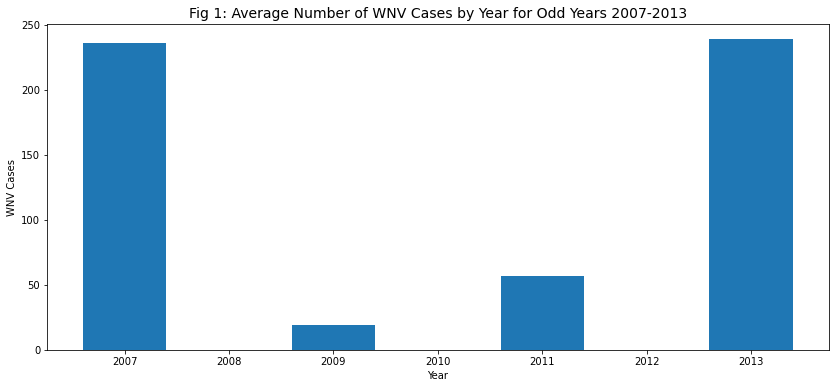

In [36]:
wnv_avg = train.groupby(['year'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.ylabel('WNV Cases')
plt.xlabel('Year')
plt.bar(wnv_avg['year'], wnv_avg['wnv_present'])
plt.title('Fig 1: Average Number of WNV Cases by Year for Odd Years 2007-2013', fontsize=14);

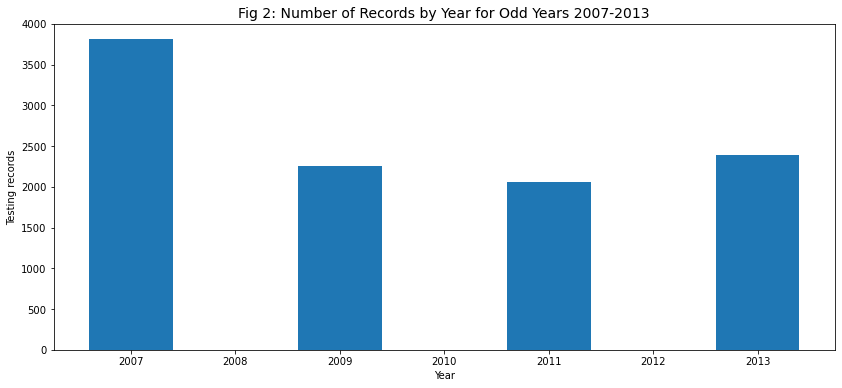

In [37]:
wnv_avg = train.groupby(['year'], as_index=False)['date'].count()
plt.figure(figsize=(14,6))
plt.bar(wnv_avg['year'], wnv_avg['date'])
plt.ylabel('Testing records')
plt.xlabel('Year')
plt.title('Fig 2: Number of Records by Year for Odd Years 2007-2013', fontsize=14);

### Weather Trends on WNV Cases

From **Figs 3-6** below, weather features were plotted against the number of WNV cases to examine if there are any patterns. Weather features which show certain patterns are ideal candidates to add into our model's features.

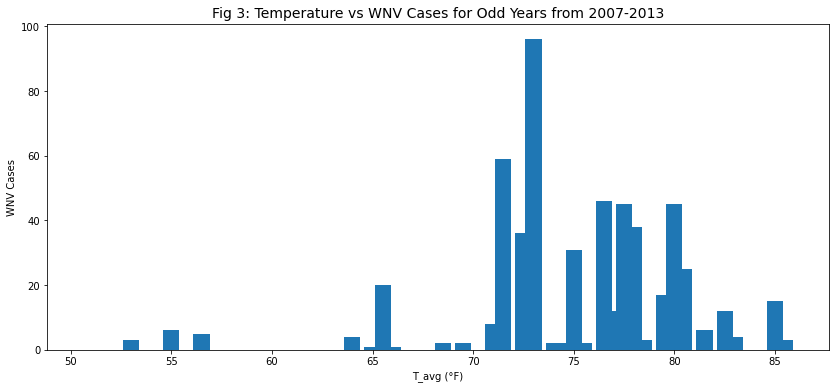

In [38]:
temp = train.groupby(['tavg'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(temp['tavg'], temp['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('T_avg (°F)')
plt.title('Fig 3: Temperature vs WNV Cases for Odd Years from 2007-2013', fontsize=14);

Higher Temperatures (>70 deg F) is associated with increases in WNV cases


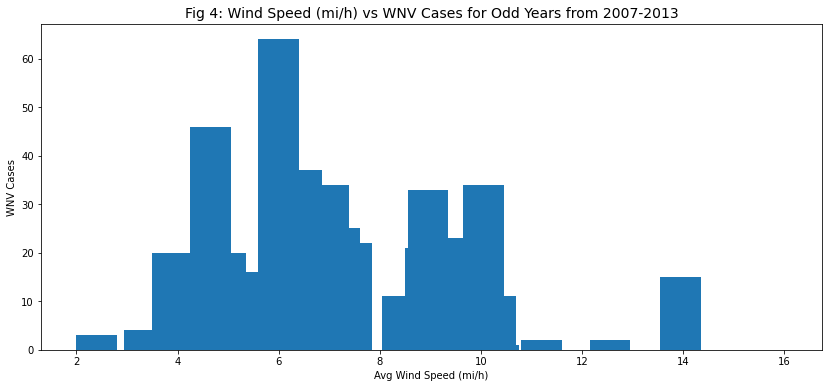

In [39]:
wind= train.groupby(['avg_speed'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(wind['avg_speed'], wind['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('Avg Wind Speed (mi/h)')
plt.title('Fig 4: Wind Speed (mi/h) vs WNV Cases for Odd Years from 2007-2013', fontsize=14);

It seems that lower wind speeds (<8 mi/hr) is associated with increases in WNV incidences in mosquitoes.

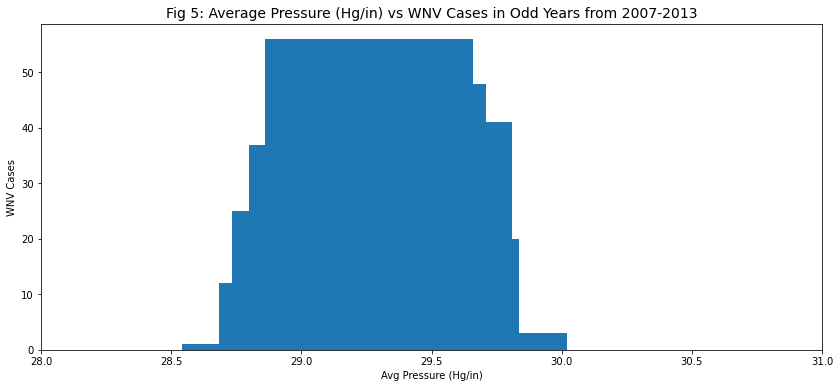

In [40]:
stn_pressure = train.groupby(['stn_pressure'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(stn_pressure['stn_pressure'], stn_pressure['wnv_present'])
plt.xlim((28,31))
plt.ylabel('WNV Cases')
plt.xlabel('Avg Pressure (Hg/in)')
plt.title('Fig 5: Average Pressure (Hg/in) vs WNV Cases in Odd Years from 2007-2013', fontsize=14);

The majority of WNV cases were observed when the air pressure was between between 28.6-29.8 Hg.

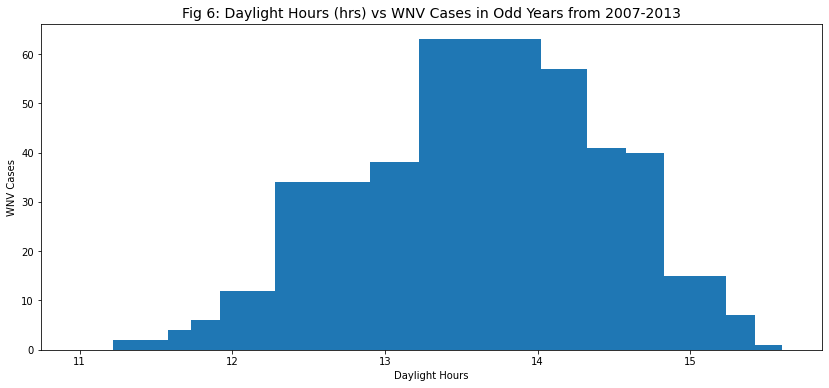

In [41]:
daylight = train.groupby(["daylight_hours"], as_index=False)["wnv_present"].sum()
plt.figure(figsize=(14, 6))
plt.bar(daylight["daylight_hours"], daylight["wnv_present"])
plt.ylabel("WNV Cases")
plt.xlabel("Daylight Hours")
plt.title(
    "Fig 6: Daylight Hours (hrs) vs WNV Cases in Odd Years from 2007-2013", fontsize=14
);

The majority of WNV cases were recorded between 13.5-14.2 daylight hours


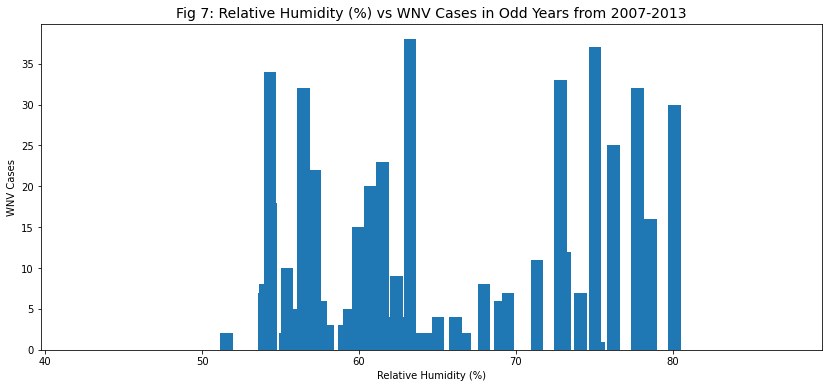

In [42]:
rh = train.groupby(["r_humidity"], as_index=False)["wnv_present"].sum()
plt.figure(figsize=(14, 6))
plt.bar(rh["r_humidity"], rh["wnv_present"])
plt.ylabel("WNV Cases")
plt.xlabel("Relative Humidity (%)")
plt.title(
    "Fig 7: Relative Humidity (%) vs WNV Cases in Odd Years from 2007-2013", fontsize=14
);

There were no WNV cases when the RH was below 50.

## Seasonal Trends

To see if there was any seasonal trend within a year for WNV cases, the mean cases per week of the year was plotted from the train dataset in **Fig 8** (i.e. number of WNV cases recorded per week/number of records per week)

From **Fig 8**, a gradual build-up and peaking of mean WNV cases in weeks 33-35 can be observed, followed by a gradual tapering till week 40. The black lines indicate the rough weeks of the peaking of the virus incidences, and the red lines indicate the boundaries where the virus tapers off.

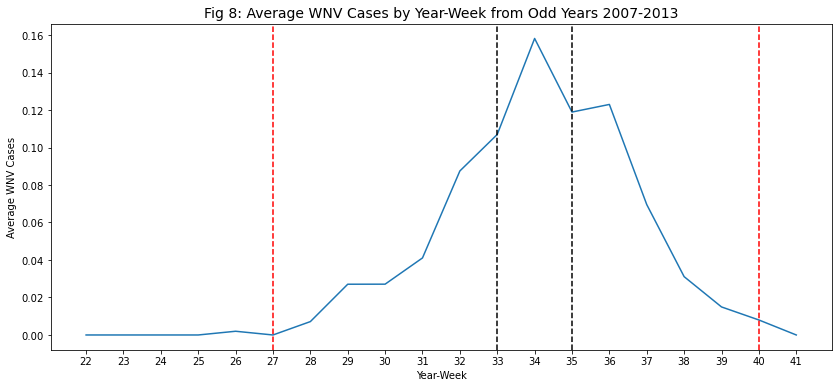

In [43]:
wnv_avg = train.groupby(['week_of_year'], as_index=False)['wnv_present'].mean()
plt.figure(figsize=(14,6))
plt.plot(wnv_avg['week_of_year'], wnv_avg['wnv_present'])
plt.xticks(range(22,42))
plt.ylabel('Average WNV Cases') 
plt.xlabel('Year-Week')
plt.title('Fig 8: Average WNV Cases by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black');

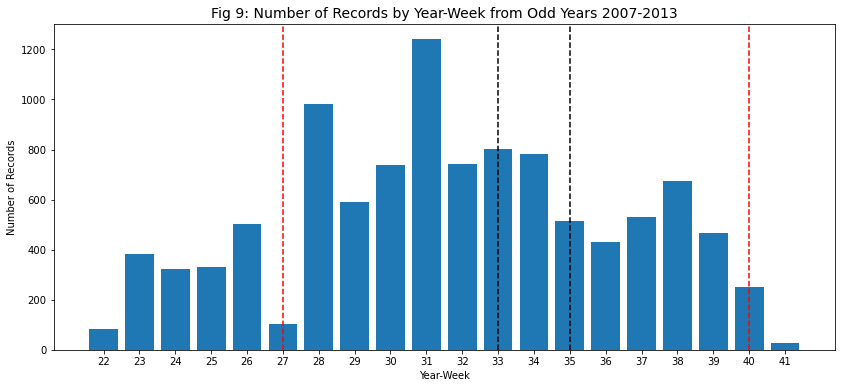

In [44]:
records = train.groupby(['week_of_year'], as_index=False)['date'].count()
plt.figure(figsize=(14,6))
plt.bar(records['week_of_year'], records['date'])
plt.xticks(range(22,42))
plt.ylabel('Number of Records')  
plt.xlabel('Year-Week')
plt.title('Fig 9: Number of Records by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black');

**Fig 8** shows that the increased number of cases was not due to simply an increase in records as the distribution of the records by week of the year do not coincide with the build-up and tapering off the pattern in weeks 27 and 40 in **Fig 7**. 

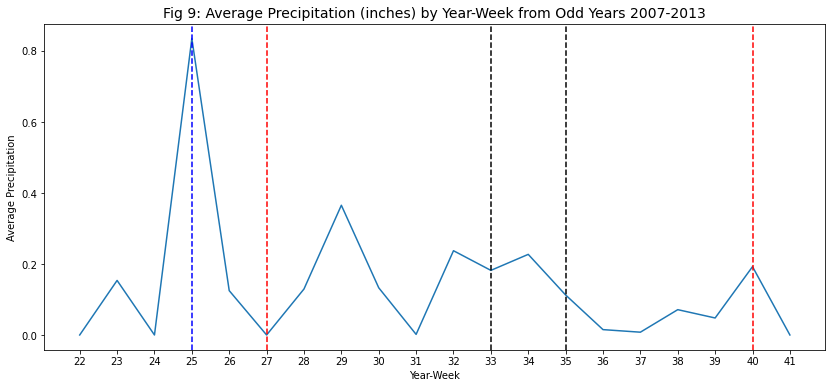

In [45]:
precip_avg = train.groupby(['week_of_year'], as_index=False)['precip_total'].mean()
plt.figure(figsize=(14,6))
plt.plot(precip_avg['week_of_year'], precip_avg['precip_total'])
plt.xticks(range(22,42))
plt.ylabel('Average Precipitation') 
plt.xlabel('Year-Week')
plt.title('Fig 9: Average Precipitation (inches) by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(25, linestyle='--', color='b')
plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black');

High precipitation rates generally results in greater generation of water surfaces for mosquito breeding, increasing the overall mosquito population and increase the chances of the spread of WNV. However, excessive precipitation also has also been known to ['flush' away mosquito larvae and decrease their life expectancy](https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0006935). The typical time for mosquitoes of the Culex species to reach adulthood is about [2-4 weeks](https://www.in.gov/health/erc/zoonotic-and-vectorborne-epidemiology-entomology/pests/culex-species-mosquitoes/), and life expectancy of the Culex species of mosquitos ranges from [2 weeks to 4 months depending on temperature.](https://pubmed.ncbi.nlm.nih.gov/25284257/)


From **Fig 9**, we observe that high precipitation usually occurs in week 25, followed by a prolonged period of low precipitation especially in weeks 27-40. It may be likely that the high rainfall from week 25 generates large amounts of suitable surfaces for mosquito breeding, with the lower precipitation in the proceeding 2 weeks (weeks 26-28) facilitating the growth of larvae into adult mosquitos and contributing to the buildup in cases from weeks 27-35.

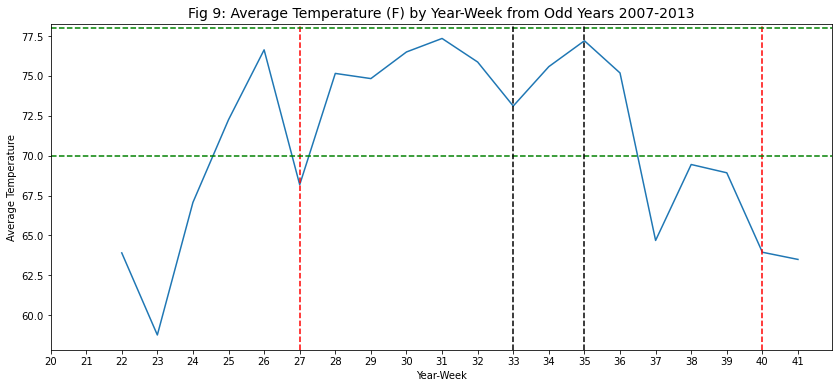

In [46]:
temp_avg = train.groupby(['week_of_year'], as_index=False)['tavg'].mean()
plt.figure(figsize=(14,6))
plt.plot(temp_avg['week_of_year'], temp_avg['tavg'])
plt.xticks(range(20,42))
plt.ylabel('Average Temperature') 
plt.xlabel('Year-Week')
plt.title('Fig 9: Average Temperature (F) by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axhline(70, linestyle='--', color='g')
plt.axhline(78, linestyle='--', color='g')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black');

Studies have shown that WNV cases generally occur when ambient temperature is between [70-79 degrees Fahrenheit](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7492091/) (indicated by the green lines). **Fig 9** seems to corroborate the studies as 
the temperature was within this band with during the peak of WNV cases (weeks 33-35).

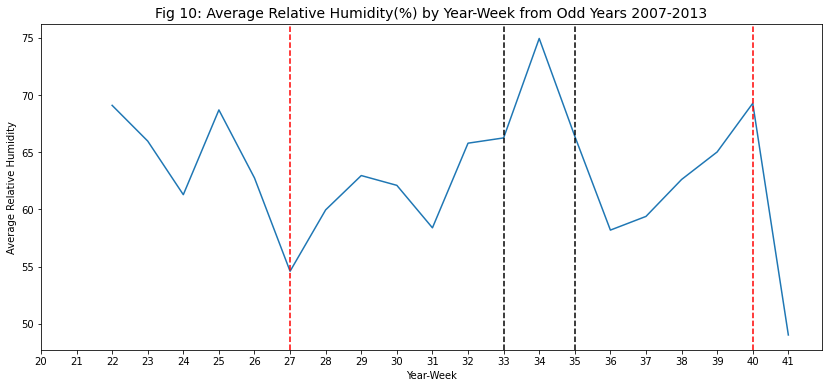

In [47]:
rh_avg = train.groupby(['week_of_year'], as_index=False)['r_humidity'].mean()
plt.figure(figsize=(14,6))
plt.plot(rh_avg['week_of_year'], rh_avg['r_humidity'])
plt.xticks(range(20,42))
plt.ylabel('Average Relative Humidity') 
plt.xlabel('Year-Week')
plt.title('Fig 10: Average Relative Humidity(%) by Year-Week from Odd Years 2007-2013', fontsize=14)
plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black');

The RH values shown in **Fig 10** follows the trend of WNV cases in **Fig 8**.

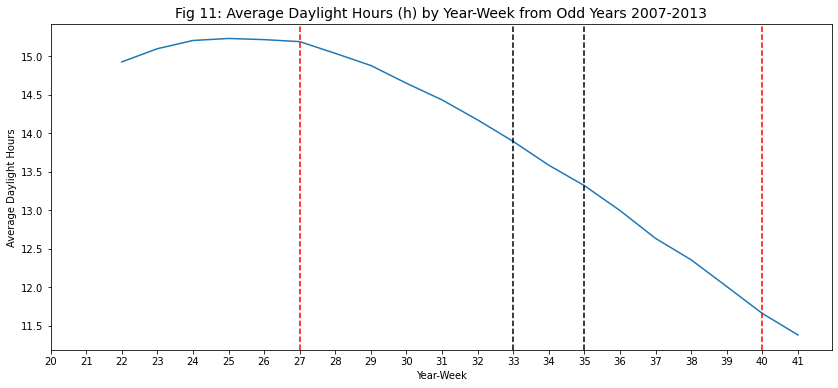

In [48]:
daylight_avg = train.groupby(['week_of_year'], as_index=False)['daylight_hours'].mean()
plt.figure(figsize=(14,6))
plt.plot(daylight_avg['week_of_year'], daylight_avg['daylight_hours'])
plt.xticks(range(20,42))
plt.ylabel('Average Daylight Hours') 
plt.xlabel('Year-Week')
plt.title('Fig 11: Average Daylight Hours (h) by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black');

The average daylight hours recorded decreases from week 27 onwards as seen from **Fig 11**, which may indicate that the increase in nighttime hours/decrease in daytime hours may exacerbate mosquito activity and lead to an increase in WNV cases.

### WNV Cases by Mosquito Species

From **Fig 12** & **Fig 13**, it can be seen that the main species which are trapped and found to have the WNV are the CULEX RESTUANS, CULEX PIPIENS, and CULEX PIPIENS/RESTUANS. WNV was not found on the other four species of mosquitoes despite records of trapping all 7 species.

As the `num_mosquitos` feature is not in `test` dataset, we would need to impute values to create that feature for the `test` dataset, this would likely create an additional layer of complexity which may not improve our model. As such, we will drop the `num_mosquitos` feature before modelling.

As the species feature is a nominal variable, we will create dummified variables and place the other mosquito species under the 'OTHERS' category to reduce the number of unnecessary features for modeling later.

                  species  num_mosquitos
0         CULEX ERRATICUS              7
1           CULEX PIPIENS          44671
2  CULEX PIPIENS/RESTUANS          66268
3          CULEX RESTUANS          23431
4        CULEX SALINARIUS            145
5          CULEX TARSALIS              7
6         CULEX TERRITANS            510


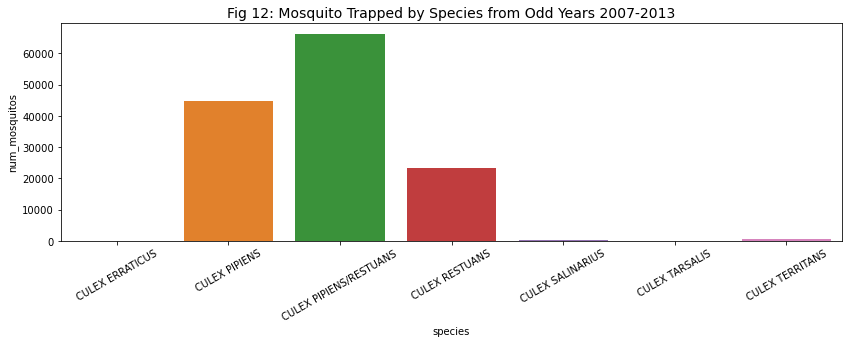

In [49]:
species_trapped = train.groupby(['species'], as_index=False)['num_mosquitos'].sum()
print(species_trapped)
plt.figure(figsize=(14,4))
sns.barplot(species_trapped['species'], species_trapped['num_mosquitos'])
plt.xticks(rotation=30)
plt.title('Fig 12: Mosquito Trapped by Species from Odd Years 2007-2013', fontsize=14);

                  species  wnv_present
0         CULEX ERRATICUS            0
1           CULEX PIPIENS          240
2  CULEX PIPIENS/RESTUANS          262
3          CULEX RESTUANS           49
4        CULEX SALINARIUS            0
5          CULEX TARSALIS            0
6         CULEX TERRITANS            0


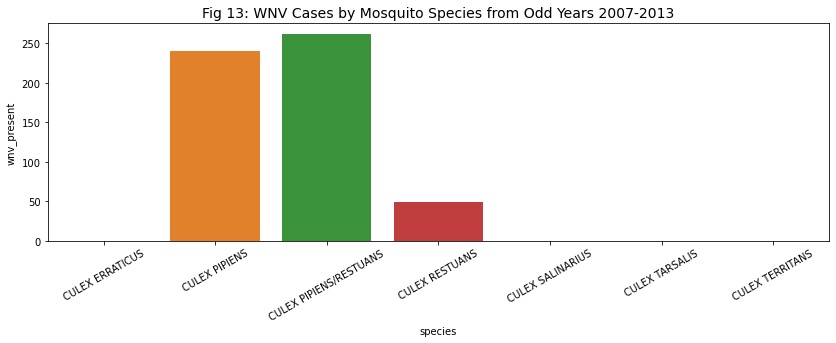

In [50]:
species_wnv = train.groupby(['species'], as_index=False)['wnv_present'].sum()
print(species_wnv)
plt.figure(figsize=(14,4))
sns.barplot(species_wnv['species'], species_wnv['wnv_present'])
plt.xticks(rotation=30)
plt.title('Fig 13: WNV Cases by Mosquito Species from Odd Years 2007-2013', fontsize=14);

In [51]:
# one-hot encoding the mosquito species
majority_species = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
train['species'] = train['species'].apply(lambda x: 'OTHERS' if x not in majority_species else x)
train = pd.get_dummies(train, columns=['species'], drop_first=True)
test = pd.get_dummies(test, columns=['species'], drop_first=True)

### Spray Effectiveness

From the spray dataset, we observe that spraying was done in 2011 and 2013 on several occasions. In **Figs 14-17** we can see the weeks that the sprays were conducted for 2011 and 2013 respectively.

From **Figs 14-15** we can observe that spraying was not seen to be effective as the number of mosquitos and WNV cases did not decrease (assuming that the number of mosquitoes trapped is a proxy measure of the mosquito population in Chicago).

In [52]:
unique_spray_2011 = spray[spray['year']==2011]['week_of_year'].unique()
unique_spray_2013 = spray[spray['year']==2013]['week_of_year'].unique()

train2011 = train[train['year']==2011]
spray2011 = train2011.groupby('week_of_year',as_index=False)['num_mosquitos'].sum()
spray2011_wnv = train2011.groupby('week_of_year',as_index=False)['wnv_present'].sum()

train2013 = train[train['year']==2013]
spray2013 = train2013.groupby('week_of_year',as_index=False)['num_mosquitos'].sum()
spray2013_wnv = train2013.groupby('week_of_year',as_index=False)['wnv_present'].sum()

FileNotFoundError: [Errno 2] No such file or directory: 'plots/2011_spray.png'

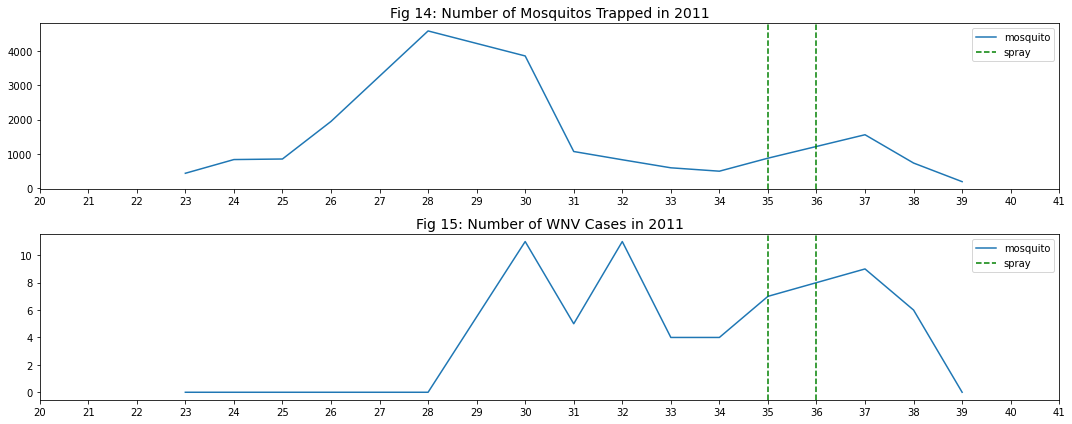

In [53]:
# comparing num mosquitos trapped and wnv cases after spraying
fig, ax = plt.subplots(nrows=2, figsize=(15,6))

ax[0].plot(spray2011['week_of_year'], spray2011['num_mosquitos'])
ax[0].set_title('Fig 14: Number of Mosquitos Trapped in 2011', fontsize=14)
ax[0].set_xticks(range(20,42))
for date in unique_spray_2011:
    ax[0].axvline(date, linestyle='--', color='g')
ax[0].legend(['mosquito', 'spray'], loc='upper right')

    
ax[1].plot(spray2011_wnv['week_of_year'], spray2011_wnv['wnv_present'])
ax[1].set_title('Fig 15: Number of WNV Cases in 2011', fontsize=14)
ax[1].set_xticks(range(20,42))
for date in unique_spray_2011:
    ax[1].axvline(date, linestyle='--', color='g')
ax[1].legend(['mosquito', 'spray'], loc='upper right')

plt.tight_layout()
plt.savefig('plots/2011_spray.png')

From **Figs 16-17** we can observe that there were more spraying conducted in 2013. The effectiveness of spraying was inconclusive as the number of mosquitos decreased in the proceeding weeks after spraying but the number of WNV cases did not decrease. This means that other factors are in play and responsible for the spread of the virus apart from the numbers in the mosquito population.

We will be revisiting the plots below during the Cost-Benefit Analysis in Part 2.

FileNotFoundError: [Errno 2] No such file or directory: 'plots/2013_spray.png'

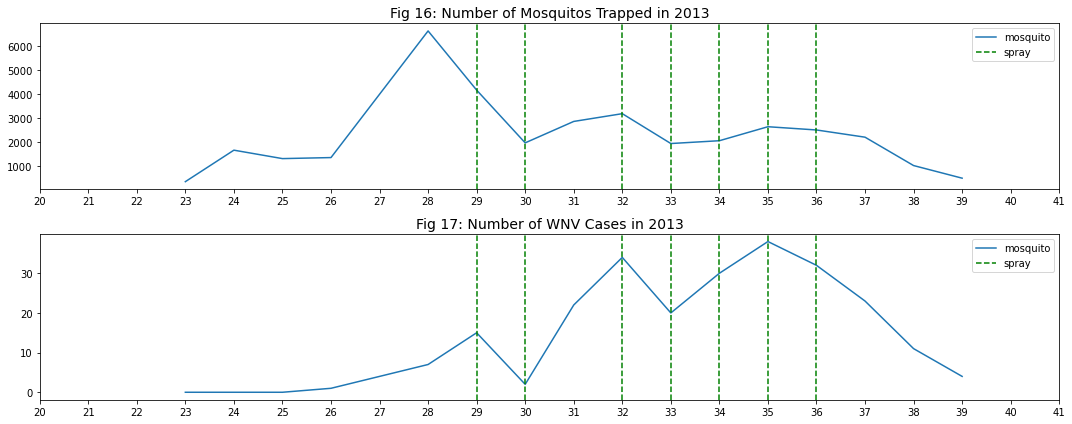

In [54]:
# comparing num mosquitos trapped and wnv cases after spraying
fig, ax = plt.subplots(nrows=2, figsize=(15,6))

ax[0].plot(spray2013['week_of_year'], spray2013['num_mosquitos'])
ax[0].set_title('Fig 16: Number of Mosquitos Trapped in 2013', fontsize=14)
ax[0].set_xticks(range(20,42))
for date in unique_spray_2013:
    ax[0].axvline(date, linestyle='--', color='g')
ax[0].legend(['mosquito', 'spray'], loc='upper right')

ax[1].plot(spray2013_wnv['week_of_year'], spray2013_wnv['wnv_present'])
ax[1].set_title('Fig 17: Number of WNV Cases in 2013', fontsize=14)
ax[1].set_xticks(range(20,42))
for date in unique_spray_2013:
    ax[1].axvline(date, linestyle='--', color='g')
ax[1].legend(['mosquito', 'spray'], loc='upper right')

plt.tight_layout()
plt.savefig('plots/2013_spray.png')

In [58]:
# drop num_mosquitos from train before finalizing train dataset for modelling
train.drop('num_mosquitos', axis=1, inplace=True)

# Export Data

In [59]:
train.to_csv('data/train_cleaned.csv', index = False)

In [60]:
test.to_csv('data/test_cleaned.csv', index = False)

In [61]:
spray.to_csv('data/spray_cleaned.csv',index=False)

# Next Step

In the next notebook, we will be proceeding with the modeling process with the cleaned data sets that were exported.